In [23]:
import pytesseract
from pytesseract import Output
from PIL import Image
import cv2
import re
import numpy as np
import glob
import json
import pandas as pd
import sklearn
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_extraction import text 

In [2]:
# pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract'
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chrus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chrus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Chrus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# convert all images in dir to jpg
def to_format(ext, to_ext, inp, out, label):
    
    img_list = glob.glob('{dir}/*.{ext}'.format(dir=inp, ext=ext))
    print('total amount of files: ' + str(amount))
    for im, i in zip(img_list, range(len(img_list))):
        
        try:
            im = Image.open(im)
            im = im.convert('RGB')
            im.save('{output}/{label}{id}.{ext}'.format(output=out, label=label, id=i, ext=to_ext))
        
            print("Status: {perc}% done.".format(perc=str(((idx+1) / len(img_list)) * 100) + "%"))
        except Exception as e:
            print(e)
            pass
        
           
        print("finished writing {percentage} percent...".format(percentage=math.ceil((100/len(labels))*(idx+1))))

In [ ]:
to_format('png','jpg', './data/lieferbeleg/raw', './data/lieferbeleg/', 'lieferbeleg')

In [ ]:
def binarize(im):
    """
    binarize image to improve accuracy
    """
    _ ,im = cv2.threshold(np.array(im),127,255,cv2.THRESH_BINARY)
    return Image.fromarray(im)

In [ ]:

def extract_text(im):
    """
    extract text of given image
    :param im: image to extract text from
    """
    im = Image.open(im)
    im = binarize(im)
    
    extracted = pytesseract.image_to_string(im, output_type=Output.DICT, lang='deu')
    return extracted

In [ ]:
def texts_to_list(input_dir, label):
    
    cap = 700
    res = []
    ext = "jpg"
    img_list = glob.glob('{dir}/*.{ext}'.format(dir=input_dir, ext=ext))
    print('amount files: {amount}'.format(amount = len(img_list)))
    for im, i in zip(img_list[:cap], range(len(img_list[:cap]))):
        
        extracted_text = extract_text(im)
        extracted_text['id'] = i +1
        extracted_text['label'] = label
        res.append(extracted_text)
        
        print("Status: {perc}% done.".format(perc=str(((i+1) / len(img_list[:cap])) * 100) + "%"))
   
    return res

In [ ]:
list_rb = texts_to_list('/Users/ct/local/rechnungsbeleg', label='invoice')

In [ ]:
list_rg = texts_to_list('/Users/ct/local/regressforderung', label='regress')

In [ ]:
with open('./data/rechnungsbeleg/invoice_data.json', 'w') as json_file:
    json.dump(list_rb, json_file)
with open('./data/regress/regress_data.json', 'w') as json_file:
    json.dump(list_rg, json_file)

In [101]:
df_inv=pd.read_json("./data/rechnungsbeleg/invoice_data.json")
df_re=pd.read_json("./data/regress/regress_data.json")
df = pd.concat([df_inv, df_re])

In [102]:
def normalize(df):
    
    df['text'].apply(lambda x: re.sub("(\\W)+"," ",x))
    df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) 
    df['text'].apply(lambda x: nltk.word_tokenize(x))
    df['text'].apply(lambda x: [word.lower() for word in x])    

normalize(df)  

In [103]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2)

In [104]:
from sklearn.feature_extraction.text import CountVectorizer

stop_words = set(stopwords.words("german"))
additional_stopwords = ['ok', 'de', 'hub', 'co', 'www',
                       'ag',  'm', 'gmbh', 'eda', 'uhr', 'homberg', 'kg',
                        'packstück', 'depot', 'nr', 'sendung', 'anzahl', 'eur',
                        'ctl', 'str', 'gew', 'gewicht', 'höhe', 'haus', 'frei']

new_stopwords_list = stop_words.union(additional_stopwords)
token_pattern = r'\b[^\d\W]+\b'

count_vect = CountVectorizer(stop_words = new_stopwords_list, token_pattern=token_pattern, analyzer='word', max_features=30)

word_count_vec = count_vect.fit_transform(X_train)
count_train = count_vect.fit(X_train)

word_count_vec.shape

(1120, 30)

In [105]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(word_count_vec)

In [106]:
X_train_tfidf

<1120x30 sparse matrix of type '<class 'numpy.float64'>'
	with 15048 stored elements in Compressed Sparse Row format>

In [107]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count_vect.get_feature_names(), columns=["idf_weights"])
 
df_idf.sort_values(by=['idf_weights'])[:10]

,idf_weights
spedition,1.603611
regressforderung,1.697617
inhalt,1.697617
versanddatum,1.701208
bearbeiter,1.703008
versanddepot,1.703008
empfangsdepot,1.704812
frankatur,1.713878
service,1.723027
umschlag,1.724867


In [108]:
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [109]:

text_clf = Pipeline([('vect', CountVectorizer(stop_words = new_stopwords_list, token_pattern=token_pattern, analyzer='word', max_features=30)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

text_clf = text_clf.fit(X_train, y_train)

In [110]:
from sklearn.metrics import classification_report


y_pred = text_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     invoice       0.98      0.93      0.96       138
     regress       0.94      0.99      0.96       142

    accuracy                           0.96       280
   macro avg       0.96      0.96      0.96       280
weighted avg       0.96      0.96      0.96       280



In [111]:
from sklearn.model_selection import cross_val_score, cross_val_predict

scores = cross_val_score(text_clf, X_test, y_test, cv=6)
predictions = cross_val_predict(text_clf, X_test, y_test, cv=6)

scores

array([0.95744681, 0.87234043, 0.91489362, 0.9787234 , 0.93478261,
       0.91304348])

(2.0, 0.0)

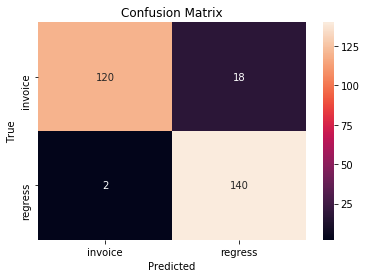

In [112]:
from sklearn.metrics import confusion_matrix
np.set_printoptions(suppress=True)
labels =["invoice", "regress"]
cm = confusion_matrix(y_test, predictions, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_xlabel('Predicted');
ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [100]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.93 (+/- 0.08)


In [53]:
import pickle

filename = 'txt_clf_model.sav'
pickle.dump(text_clf, open(filename, 'wb'))